In [1]:
import torch
import pandas as pd
import numpy as np
import re
import random

import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import lr_scheduler

from tqdm.autonotebook import tqdm

#nltk
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
import string

#!pip install git+https://github.com/gmihaila/ml_things
#from ml_things import plot_dict

from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tokenizers import ByteLevelBPETokenizer
from transformers import RobertaModel, RobertaConfig
from torch.utils.data import Dataset, DataLoader

from transformers import logging
logging.set_verbosity_warning()
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\南京中略信息技术有限公司\AppData\Local\Temp\ipykernel_20248\4275997296.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
train_df = pd.read_csv('./input/train.csv')
train_df.drop(314, inplace=True) # This row was found to have 'nan' values, so dropping it
train_df.reset_index(drop=True, inplace=True)
train_df['text'] = train_df['text'].astype(str)
train_df['selected_text'] = train_df['selected_text']

test_df = pd.read_csv('./input/test.csv').reset_index(drop=True)
test_df['text'] = test_df['text'].astype(str)

train_loss = []
val_loss = []
jac_train = []
jac_val = []

Text(0.5, 0, 'Sentiment balance in the data')

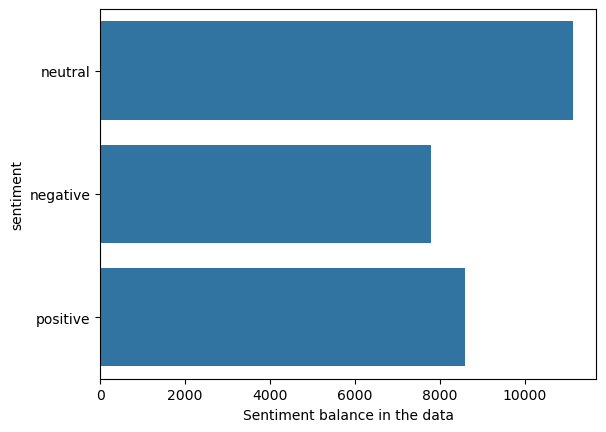

In [3]:
import seaborn as sns
ax = sns.countplot(train_df.sentiment)
plt.xlabel('Sentiment balance in the data')

In [4]:
PATH = "./roberta"

tokenizer = ByteLevelBPETokenizer(
            vocab = f'{PATH}/vocab.json', 
            merges= f'{PATH}/merges.txt', 
            add_prefix_space = True,
            lowercase=True)

tokenizer.enable_truncation(max_length=512)    # since length cannot be set, use enable_truncation() instead

In [5]:
MAX_LENGTH = 100
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 5

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
val1 = tokenizer.encode('negative').ids
val2 = tokenizer.encode('positive').ids
val3 = tokenizer.encode('neutral').ids
val1, val2, val3

([2430], [1313], [7974])

In [8]:
class TextDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_length):
        #data loading
        self.df = df
        self.selected_text = "selected_text" in df
        self.tokenizer = tokenizer
        self.max_length = MAX_LENGTH
        
    def __len__(self):
        #len(dataset) i.e., the total number of samples
        return len(self.df)
    
    '''
    def cleanText(self, text):
        #clean the text
        text = str(text).lower()
        text = re.sub('\[.*?\]', '', text)
        text = ' '.join([word for word in text.split(' ') if word not in stop])
        text = text.encode('ascii', 'ignore').decode()
        text = re.sub(r'https*\S+', ' ', text)
        text = re.sub(r'@\S+', ' ', text)
        text = re.sub(r'#\S+', ' ', text)
        text = re.sub(r'\'\w+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        text = re.sub(r'\w*\d+\w*', '', text)
        text = re.sub(r'\s{2,}', ' ', text)
        text = re.sub(r"^\s+|\s+$", "", text) 
        #text = re.sub(r'[^a-zA-Z\']', ' ', text)
        #text = re.sub(r'[^\x00-\x7F]+', '', text)
        return text
    '''

    
    def get_data(self, row):
        #processing the data
        text = " "+" ".join(row.text.lower().split()) # clean the text
        encoded_input = self.tokenizer.encode(text) # the sentence to be encoded
        
        sentiment_id = {
                'positive': 1313,
                'negative': 2430,
                'neutral': 7974
            }  # stating the ids of the sentiment values 
        
        #print ([list((i, encoded_input[i])) for i in range(len(encoded_input))])
        '''
        # The input_ids are the sentence or sentences represented as tokens. 
        # There are a few BERT special tokens that one needs to take note of:

        # [CLS] - Classifier token, value: [101] 
        # [SEP] - Separator token, value: [102]
        # [PAD] - Padding token, value: 0

        # Bert expects every row in the input_ids to have the special tokens included as follows:

        # For one sentence as input:
        # [CLS] ...word tokens... [SEP]

        # For two sentences as input:
        # [CLS] ...sentence1 tokens... [SEP]..sentence2 tokens... [SEP]
        '''
        
        input_ids = [101] + [sentiment_id[row.sentiment]] + [102] + encoded_input.ids + [102]
            
        '''
        id: unique identifier for each token
        offset: starting and ending point in a sentence
        '''        
                 
        #ID offsets       
        offsets = [(0, 0)] * 3 + encoded_input.offsets + [(0, 0)]     # since first 3 are [CLS] ...sentiment tokens... [SEP]
        
        
        pad_len = self.max_length - len(input_ids)    
        if pad_len > 0:
            input_ids += ([0] * pad_len)
            offsets += ([(0, 0)] * pad_len)
                       
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        
        # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
        masks = torch.where(input_ids != 0, torch.tensor(1), torch.tensor(0))  
        '''
        # The attention mask has the same length as the input_ids(or token_type_ids). 
        # It tells the model which tokens in the input_ids are words and which are padding. 
        # 1 indicates a word (or special token) and 0 indicates padding.

        # For example:
        # Tokens: [101, 7592, 2045, 1012,  102,    0,    0,    0,    0,    0]
        # Attention mask: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
        '''
        
        masks = torch.tensor(masks, dtype=torch.long)
        offsets = torch.tensor(offsets, dtype=torch.long)
                
        return input_ids, masks, text, offsets
    
    def get_target_ids(self, row, text, offsets):
        # preparing data only for the training
        selected_text = " " + " ".join(row.selected_text.lower().split())

        string_len = len(selected_text) - 1
        
        idx0 = None
        idx1 = None
            
        for ind in (position for position, line in enumerate(text) if line == selected_text[1]):
            if " " + text[ind: ind+string_len] == selected_text:
                idx0 = ind
                idx1 = ind + string_len - 1
                break
                
        char_targets = [0] * len(text)
        if idx0 != None and idx1 != None:
            for ct in range(idx0, idx1 + 1):
                char_targets[ct] = 1
        '''
        char_targets only give 1 to the part of the selected_text within a text
        e.g: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
        Here, for the length of the text, [1] is only at the index position of the selected text.
        This helps us get the start and end indices of the selected text in the next stage.
        '''               
        # Start and end tokens
        target_idx = []
        for k, (offset1, offset2) in enumerate(offsets):
            if sum(char_targets[offset1: offset2]) > 0:
                try:
                    target_idx.append(k)
                except:
                    continue

        targets_start = target_idx[0]
        targets_end = target_idx[-1]
                
        return selected_text, targets_start, targets_end
    
   
    
    def __getitem__(self, index): # addressing each row by its index
        #dataset[index] i.e., generates one sample of data
        data = {}
        row = self.df.iloc[index]
        
        ids, masks, text, offsets = self.get_data(row)
        data['ids'] = ids
        data['masks'] = masks
        data['text'] = text
        data['offsets'] = offsets
        data['sentiment'] = row.sentiment
        
        if self.selected_text:   #checking if selected text exists
            # This part only exists in the training
            selected_text,start_index, end_index = self.get_target_ids(row, text, offsets)
            data['start_index'] = start_index
            data['end_index'] = end_index   
            data['selected_text'] = selected_text
                
        return data

In [9]:
class TextModel(nn.Module):
     
    def __init__(self):
        super(TextModel, self).__init__()
        # RoBERTa encoder 
        config = RobertaConfig.from_pretrained(
            './roberta/config.json', output_hidden_states=True)    
        self.roberta = RobertaModel.from_pretrained(
            './roberta/pytorch_model.bin', config=config)

        for param in self.roberta.parameters():
            param.requires_grad = True
    
        self.drop0 = nn.Dropout(0.15)
        self.l0 = nn.Linear(config.hidden_size * 2,config.hidden_size) 
        # Multiplied by 2 since the forward pass concatenates the last two hidden representation layers
        self.drop1 = nn.Dropout(config.hidden_dropout_prob)
        self.l1 = nn.Linear(config.hidden_size, 2)  # The output will have two dimensions- start and end logits
        torch.nn.init.normal_(self.l0.weight, std=0.02)
        torch.nn.init.normal_(self.l0.bias, 0)
        
    def forward(self, ids, masks): #, token_type_ids
        # Return the hidden states from the RoBERTa backbone
        # Type: torch tensor
        last_hidden_state, pooled_output, hidden_states = self.roberta(input_ids=ids, attention_mask=masks, return_dict=False)
        # input_ids.shape and attention_mask.shape both will be of the size (batch size x seq length)
        #print(last_hidden_state.shape) : torch.Size([24, 100, 768])
        # But why 768? 
        #This is the number of hidden units in the feedforward-networks. We can verify that by checking the config.
        '''
        About the parameters:
        
        input_ids (torch.LongTensor of shape (batch_size, sequence_length)) –
        Indices of input sequence tokens in the vocabulary.
        Indices can be obtained using Tokenizer. See transformers.PreTrainedTokenizer.encode() and transformers.PreTrainedTokenizer.__call__() for details.

        attention_mask (torch.FloatTensor of shape (batch_size, sequence_length), optional) –
        Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:
        1 for tokens that are not masked,
        0 for tokens that are masked.
        
        '''
        
        # Concatenate the last two hidden states
        out = torch.cat((hidden_states[-1], hidden_states[-2]), dim=-1)   
        #out = torch.mean(out, 0) # take the mean along axis 0
        
        # adding dropouts and linear layers
        out = self.drop0(out)
        out = F.relu(self.l0(out))
        out = self.drop1(out) 
        out = self.l1(out) 
        
        #splitting the tensor into two logits 
        start_logits, end_logits = out.split(1, dim=-1) # dimension along which to split the tensor.
        # Return a tensor with all the dimensions of input of size 1 removed, for both the logits.
        start_logits = start_logits.squeeze()  #Squeezing a tensor removes the dimensions or axes that have a length of one
        end_logits = end_logits.squeeze() 
        
        return start_logits, end_logits    

In [10]:
def train_val_dataloaders(df, train_idx, val_idx, batch_size):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_loader = torch.utils.data.DataLoader(
        TextDataset(train_df, tokenizer, MAX_LENGTH), 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,   # to avoid multi-process, keep it at 0
        drop_last=True)

    val_loader = torch.utils.data.DataLoader(
        TextDataset(val_df, tokenizer, MAX_LENGTH),
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0)

    dataloaders_dict = {"train": train_loader, "val": val_loader}

    return dataloaders_dict

In [11]:
def test_loader(df, batch_size=TEST_BATCH_SIZE):
    loader = torch.utils.data.DataLoader(
        TextDataset(test_df, tokenizer, MAX_LENGTH), 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0)    
    return loader

In [12]:
def loss_function(start_logits, end_logits, start_positions, end_positions):
    # calculating cross entropy losses for both the start and end logits
    loss = nn.CrossEntropyLoss(reduction='mean') # for a multi-class classification problem
    start_loss = loss(start_logits, start_positions)
    end_loss = loss(end_logits, end_positions)
    total_loss = (start_loss + end_loss)
    return total_loss

In [13]:
def get_selected_text(text, start_idx, end_idx, offsets):
    if end_idx < start_idx:
        end_idx = start_idx
    select_text = ""
    for idx in range(start_idx, end_idx + 1):
        select_text += text[offsets[idx][0]: offsets[idx][1]]
        if (idx + 1) < len(offsets) and offsets[idx][1] < offsets[idx + 1][0]:
            select_text += " "
    return select_text

In [14]:
# evaluation metric 
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    d = (len(a) + len(b) - len(c))
    if d != 0:
         return float(len(c) / d)
    else:
         return 0.0

In [15]:
def find_jaccard_score(text, selected_text, sentiment, offsets, start_logits, end_logits): #start_idx, end_idx
    start_pred = np.argmax(start_logits) # Predicted start index using argmax
    end_pred = np.argmax(end_logits) # Predicted end index using argmax
    if (end_pred <= start_pred) or sentiment == 'neutral' or len(text.split()) < 2:
        enc = tokenizer.encode(text)
        prediction = tokenizer.decode(enc.ids[start_pred-1:end_pred])   
    else:
        prediction = get_selected_text(text, start_pred, end_pred, offsets)
    true = selected_text
    #true = get_selected_text(text, start_idx, end_idx, offsets)
    return jaccard(true, prediction), prediction

In [16]:
def train(model, dataloaders_dict, optimizer, num_epochs, scheduler, device, filename): 
    '''
    Train pytorch model on a single pass through the data loader.
 
        This function is built with reusability in mind: it can be used as is as long
        as the `dataloader` outputs a batch in dictionary format that can be passed 
        straight into the model - `model(**batch)`.

      Some of the arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.
 
      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.
 
      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.
 
      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.
    '''
    # Set device as `cuda` (GPU)
    model.to(device)
    for epoch in range(num_epochs):
        for key in ['train', 'val']:
            if key == 'train':
                model.train()
                dataloaders = dataloaders_dict['train']
            else:
                model.eval()
                dataloaders = dataloaders_dict['val']

            epoch_loss = 0.0
            epoch_jaccard = 0.0
            
            # Set tqdm to add loading screen and set the length
            loader = tqdm(dataloaders, total=len(dataloaders))
            #print(len(dataloaders))
                        
            # loop over the data iterator, and feed the inputs to the network
            # Train the model on each batch
            for (idx, data) in enumerate(loader):
                ids = data['ids']
                masks = data['masks']
                text = data['text']
                offsets = data['offsets'].numpy()
                start_idx = data['start_index']
                end_idx = data['end_index']
                sentiment = data['sentiment']

                model.zero_grad()
                optimizer.zero_grad()
                
                ids = ids.to(device, dtype=torch.long)
                masks = masks.to(device, dtype=torch.long)
                start_idx = start_idx.to(device, dtype=torch.long)
                end_idx = end_idx.to(device, dtype=torch.long)

                with torch.set_grad_enabled(key == 'train'): 

                    start_logits, end_logits = model(ids, masks) 
                    
                    loss = loss_function(start_logits, end_logits, start_idx, end_idx)
                    
                    if key == 'train':
                        if idx != 0: 
                            loss.backward() # Perform a backward pass to calculate the gradients
                        optimizer.step() # Update parameters and take a step using the computed gradient
                        scheduler.step() # Update learning rate schedule                        
                        
                        # Clip the norm of the gradients to 1.0.
                        # This is to help prevent the "exploding gradients" problem.
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  
                        
                    epoch_loss += loss.item() * len(ids)
                    
                    # Move logits to CPU
                    # detaching these outputs so that the backward passes stop at this point
                    start_idx = start_idx.cpu().detach().numpy()
                    end_idx = end_idx.cpu().detach().numpy()
                    start_logits = torch.softmax(start_logits, dim=1).cpu().detach().numpy()
                    end_logits = torch.softmax(end_logits, dim=1).cpu().detach().numpy()
                    
                    selected_text = data['selected_text']
                    
                    filtered_sentences = []
                    for i, t_data in enumerate(text):
                    #for i in range(len(ids)):                        
                        jaccard_score, filtered_output = find_jaccard_score(
                            t_data,
                            selected_text[i],
                            sentiment[i],
                            offsets[i],
                            start_logits[i], 
                            end_logits[i])
                        epoch_jaccard += jaccard_score
                        filtered_sentences.append(filtered_output)
            
            # Calculate the average loss over the training data
            epoch_loss = epoch_loss / len(dataloaders.dataset)
            # Calculate the average jaccard score over the training data
            epoch_jaccard = epoch_jaccard / len(dataloaders.dataset)
            
            print('Epoch {}/{} | {:^5} | Loss: {:.4f} | Jaccard: {:.4f}'.format(
                epoch + 1, num_epochs, key, epoch_loss, epoch_jaccard))
            
            # Store the loss value for plotting the learning curve.
            if key == 'train':
                train_loss.append(epoch_loss)
                jac_train.append(epoch_jaccard)
                
            else:
                val_loss.append(epoch_loss)
                jac_val.append(epoch_jaccard)
    
    torch.save(model.state_dict(), filename)

In [17]:
def set_seed(seed):
    # Set random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        
seed = 777
set_seed(seed)

In [18]:
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=seed)

In [19]:
%%time

for fold, (idxTrain, idxVal) in enumerate(skf.split(train_df, train_df.sentiment), start=1):
    
    print('#'*10)
    print('### FOLD %i'%(fold))
    print('#'*10)
    
    model = TextModel()
    optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01, correct_bias=False)
    dataloaders_dict = train_val_dataloaders(train_df, idxTrain, idxVal, batch_size=TRAIN_BATCH_SIZE)
    num_training_steps = int(len(train_df) / EPOCHS * TRAIN_BATCH_SIZE)
    # warmup_proportion = float(num_warmup_steps) / float(num_training_steps)
    scheduler = get_linear_schedule_with_warmup(
                  optimizer,
                  num_warmup_steps=0, #default #use a linear scheduler with no warmup steps
                  num_training_steps=num_training_steps
                )    
    train(
        model, 
        dataloaders_dict, 
        optimizer, 
        EPOCHS,
        scheduler,
        device,
        f'bert_fold{fold}.pth')

##########
### FOLD 1
##########


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 1/5 | train | Loss: 3.5933 | Jaccard: 0.3875


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 1/5 |  val  | Loss: 1.7773 | Jaccard: 0.4928


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 2/5 | train | Loss: 1.7611 | Jaccard: 0.5077


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 2/5 |  val  | Loss: 1.7243 | Jaccard: 0.5425


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 3/5 | train | Loss: 1.5910 | Jaccard: 0.5175


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 3/5 |  val  | Loss: 1.7632 | Jaccard: 0.5015


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 4/5 | train | Loss: 1.4305 | Jaccard: 0.5304


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 4/5 |  val  | Loss: 1.7401 | Jaccard: 0.4964


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 5/5 | train | Loss: 1.2575 | Jaccard: 0.5477


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 5/5 |  val  | Loss: 1.8578 | Jaccard: 0.4952
##########
### FOLD 2
##########


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 1/5 | train | Loss: 2.0470 | Jaccard: 0.4926


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 1/5 |  val  | Loss: 1.6963 | Jaccard: 0.5265


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 2/5 | train | Loss: 1.5900 | Jaccard: 0.5140


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 2/5 |  val  | Loss: 1.6621 | Jaccard: 0.4746


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 3/5 | train | Loss: 1.4488 | Jaccard: 0.5245


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 3/5 |  val  | Loss: 1.6557 | Jaccard: 0.4869


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 4/5 | train | Loss: 1.2927 | Jaccard: 0.5412


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 4/5 |  val  | Loss: 1.6975 | Jaccard: 0.5199


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 5/5 | train | Loss: 1.1242 | Jaccard: 0.5607


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 5/5 |  val  | Loss: 1.9148 | Jaccard: 0.5109
##########
### FOLD 3
##########


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 1/5 | train | Loss: 2.0054 | Jaccard: 0.4938


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 1/5 |  val  | Loss: 1.6767 | Jaccard: 0.4977


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 2/5 | train | Loss: 1.6056 | Jaccard: 0.5082


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 2/5 |  val  | Loss: 1.6515 | Jaccard: 0.5079


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 3/5 | train | Loss: 1.4152 | Jaccard: 0.5269


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 3/5 |  val  | Loss: 1.7228 | Jaccard: 0.5296


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 4/5 | train | Loss: 1.2492 | Jaccard: 0.5429


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 4/5 |  val  | Loss: 1.8279 | Jaccard: 0.5369


  0%|          | 0/1145 [00:00<?, ?it/s]

Epoch 5/5 | train | Loss: 1.0696 | Jaccard: 0.5672


  0%|          | 0/573 [00:00<?, ?it/s]

Epoch 5/5 |  val  | Loss: 2.0883 | Jaccard: 0.5231
CPU times: total: 1h 52min 47s
Wall time: 2h 6min 39s


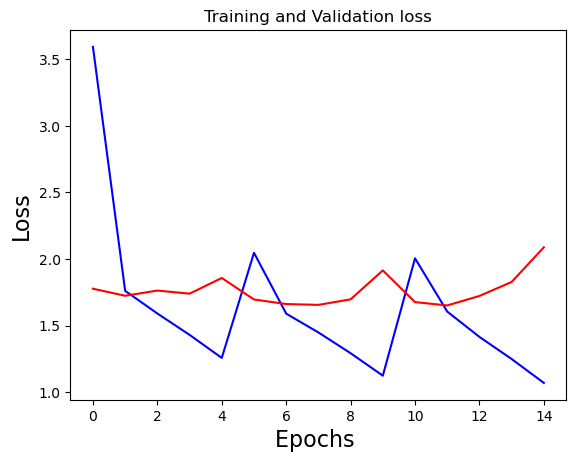

In [20]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.show()

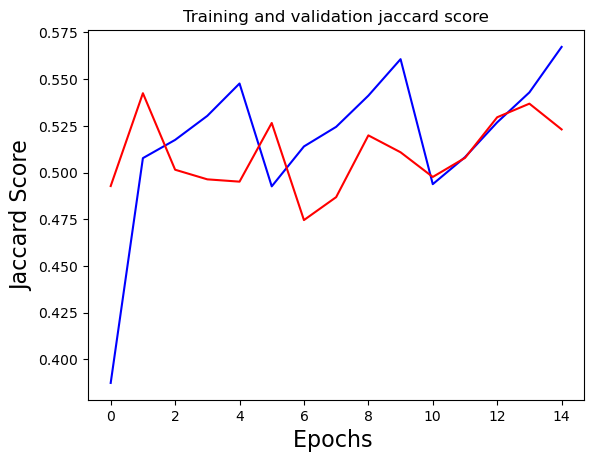

In [21]:
plt.plot(range(len(jac_train)), jac_train, 'b', label='Training jaccard score')
plt.plot(range(len(jac_val)), jac_val, 'r', label='Validation jaccard score')
plt.title('Training and validation jaccard score')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Jaccard Score',fontsize=16)
plt.show()

In [22]:
%%time

t_loader = test_loader(test_df)
predictions = []
models = []
for fold in range(skf.n_splits):
    model = TextModel()
    model.to(device)
    model.load_state_dict(torch.load(f'./bert_fold{fold+1}.pth'))
    model.eval()
    models.append(model)

loader = tqdm(t_loader, total=len(t_loader))
for (idx, data) in enumerate(loader):
    ids = data['ids'].to(device)
    masks = data['masks'].to(device)
    text = data['text']
    offsets = data['offsets'].numpy()

    start_logits = []
    end_logits = []
    for model in models:
        with torch.no_grad():
            output = model(ids, masks)
            start_logits.append(torch.softmax(output[0], dim=1).cpu().detach().numpy())
            end_logits.append(torch.softmax(output[1], dim=1).cpu().detach().numpy())

    start_logits = np.mean(start_logits, axis=0)
    end_logits = np.mean(end_logits, axis=0)
    
    for i, t_data in enumerate(text):
        start_pred = np.argmax(start_logits[i])
        end_pred = np.argmax(end_logits[i])
        if start_pred >= end_pred:
            enc = tokenizer.encode(t_data)
            prediction = tokenizer.decode(enc.ids[start_pred-1:end_pred])
        else:
            prediction = get_selected_text(t_data, start_pred, end_pred, offsets[i])
        predictions.append(prediction)

  0%|          | 0/221 [00:00<?, ?it/s]

CPU times: total: 1min 19s
Wall time: 1min 26s


In [23]:
sub_df = pd.read_csv('./input/sample_submission.csv')
sub_df['selected_text'] = predictions
# post-processing trick
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
sub_df[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)

In [24]:
sub_df.sample(25)

,textID,selected_text
1988,faee4563bd,..congrats
1085,0144252776,"and, yes. i <3 mac, if only it weren`t so expensive"
424,0693a85163,boring.
1815,59ee5ff2f9,of
432,d7746b6b68,is listening to p!nk tunage and trying to teach my cat ...
2963,08ad89c6b0,yayy.
2437,a1b12787c2,rare treat
980,67cafda653,i am public and can`t get anyone to follow me
3012,9f89432794,missing my big girl.
712,c9e5ca399a,i miss you.
